<a href="https://colab.research.google.com/github/kpamungkas/DMN_FoG-ED/blob/main/3DCNN_Final_DMN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D Convolutional Neural Network of DMN-masked RSFC maps on DBS-induced FoG Classification

# Setting Up

In [ ]:
# Setting Up
# Source : https://keras.io/examples/vision/3D_image_classification/
import os
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# Load Data

In [ ]:
# Loading nifti data and preprocessing
import nibabel as nib
from scipy import ndimage

def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def process_scan(path):
    """Read volume"""
    # Read scan
    volume = read_nifti_file(path)
    return volume

In [ ]:
"""Load Dataset"""
# Folder "Worsening" consist of RSFCMaps of subjects who showed worsening in FoG
# due to DBS stimulation.
trainingset_worsen_paths = [
    os.path.join("/content/drive/MyDrive/Master Thesis/DMN/Worsening", x)
    for x in os.listdir("/content/drive/MyDrive/Master Thesis/DMN/Worsening")
]

# Folder "Stay" consist of RSFCMaps of subjects who showed no change in FoG
# due to DBS stimulation.
trainingset_no_paths = [
    os.path.join("/content/drive/MyDrive/Master Thesis/DMN/Stay", x)
    for x in os.listdir("/content/drive/MyDrive/Master Thesis/DMN/Stay")
]

# Folder "Improved" consist of RSFCMaps of subjects who showed improvement in FoG
# due to DBS stimulation.
trainingset_improve_paths = [
    os.path.join("/content/drive/MyDrive/Master Thesis/DMN/Improved", x)
    for x in os.listdir("/content/drive/MyDrive/Master Thesis/DMN/Improved")
]

print("RSFCMaps with worsening FoG: " + str(len(trainingset_worsen_paths)))
print("RSFCMaps with no change FoG: " + str(len(trainingset_no_paths)))
print("RSFCMaps with improved FoG: " + str(len(trainingset_improve_paths)))

RSFCMaps with worsening FoG: 11
RSFCMaps with no change FoG: 6
RSFCMaps with improved FoG: 34


# Split Dataset

In [ ]:
"""Read datasets and split to training and test data"""

# Read RSFCMaps from the trainingset and store them in a 4D array according to FoG change.
worsen_maps = np.array([process_scan(path) for path in trainingset_worsen_paths])
nochange_maps = np.array([process_scan(path) for path in trainingset_no_paths])
improve_maps = np.array([process_scan(path) for path in trainingset_improve_paths])

# Assign 0 for worsen_maps, 1 for nochange_maps, and 2 for improve_maps.
worsen_labels = np.array([0 for _ in range(len(worsen_maps))])
nochange_labels = np.array([1 for _ in range(len(nochange_maps))])
improve_labels = np.array([2 for _ in range(len(improve_maps))])

# Split data: 41 to training and 10 to test.
x_train = np.concatenate((worsen_maps[:6], worsen_maps[8:10], nochange_maps[:5], improve_maps[:16], improve_maps[19:31]), axis=0)
y_train = np.concatenate((worsen_labels[:8], nochange_labels[:5], improve_labels[:28]), axis=0)
x_val = np.concatenate((worsen_maps[6:8], worsen_maps[10:], nochange_maps[5:], improve_maps[16:19], improve_maps[31:]), axis=0)
y_val = np.concatenate((worsen_labels[8:], nochange_labels[5:], improve_labels[28:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)


Number of samples in train and validation are 41 and 10.


# Data Augmentation

In [ ]:
""" Define data augmentation: Flip on X-, Y-, and Z-axis """

import numpy as np

def flip_x(maps): #data has to be 4d array (n sample, row, col, depth)
  # Initialize empty array
  x_data = np.zeros((len(maps), 91, 109, 91), float)

  for i in range(len(maps)):
    current_volume = maps[i]
    
    # Flip the current volume
    x_flip = current_volume[::-1, :, :]

    # Save the flipped volumes onto the empty arrays
    x_data[i] = x_flip
  
  return x_data

def flip_y(maps): #data has to be 4d array (n sample, row, col, depth)
  # Initialize empty array
  y_data = np.zeros((len(maps), 91, 109, 91), float)

  for i in range(len(maps)):
    current_volume = maps[i]
    
    # Flip the current volume
    y_flip = current_volume[:, ::-1, :]

    # Save the flipped volumes onto the empty arrays
    y_data[i] = y_flip
  
  return y_data

def flip_z(maps): #data has to be 4d array (n sample, row, col, depth)
  # Initialize empty array
  z_data = np.zeros((len(maps), 91, 109, 91), float)

  for i in range(len(maps)):
    current_volume = maps[i]
    
    # Flip the current volume
    z_flip = current_volume[:, :, ::-1]

    # Save the flipped volumes onto the empty arrays
    z_data[i] = z_flip
  
  return z_data

In [ ]:
""" Training set augmentation """

x_train_x = flip_x(x_train)
x_train_y = flip_y(x_train)
x_train_z = flip_z(x_train)

In [ ]:
""" Add augmented data to training data """

x_train = np.concatenate((x_train, x_train_x, x_train_y, x_train_z), axis=0)
y_train = np.concatenate((y_train, y_train, y_train, y_train), axis=0)

print(
    "Number of samples after augmentation in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples after augmentation in train and validation are 164 and 10.


# Data Normalization

# Prepare Data

In [ ]:
""" Prepare training set """

import random
from scipy import ndimage

def train_preprocessing(volume, label):
    """Add one dimension to each RSFCMaps in the training set."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def validation_preprocessing(volume, label):
    """Add one dimension to each RSFCMaps in the test set."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(2)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(1)
    .prefetch(2)
)

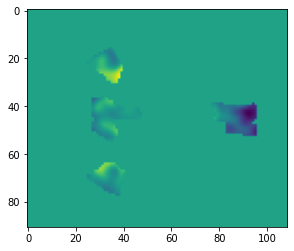

In [ ]:
""" Sample Visualisation """

import matplotlib.pyplot as plt

plt.imshow(x_train[1,:,:,52])
plt.show()

# 3D CNN

In [ ]:
""" Build a 3D CNN model"""
# tuned
# https://keras.io/examples/vision/3D_image_classification/

# Initialising the CNN
cnn = tf.keras.models.Sequential()

# 1st convolutional layer +  relu activation + pool + normalization
cnn.add(layers.Conv3D(filters=8, kernel_size=(3,3,3),  activation='relu', kernel_initializer= 'glorot_uniform', input_shape=[91, 109, 91, 1]))
cnn.add(layers.MaxPool3D((2,2,2)))
cnn.add(layers.BatchNormalization())

# 2nd convolutional layer + relu activation + pool + normalization
cnn.add(layers.Conv3D(filters=32, kernel_size=(3,3,3), activation='relu', kernel_initializer= 'glorot_uniform'))
cnn.add(layers.MaxPool3D((2,2,2)))
cnn.add(layers.BatchNormalization())

# 3rd convolutional layer + relu activation + pool + normalization
cnn.add(layers.Conv3D(filters= 64, kernel_size=(3,3,3),  activation='relu', kernel_initializer='glorot_uniform'))
cnn.add(layers.MaxPool3D((2,2,2)))
cnn.add(layers.BatchNormalization())

# 4th convolutional layer + relu activation + pool + normalization
cnn.add(layers.Conv3D(filters = 64, kernel_size=(3,3,3), activation = 'relu', kernel_initializer='glorot_uniform'))
cnn.add(layers.MaxPool3D((2,2,2)))
cnn.add(layers.BatchNormalization())

# 5th global average + pool + dropout
cnn.add(layers.GlobalAveragePooling3D())
cnn.add(layers.Dense(units = 32, activation = 'relu'))
cnn.add(layers.Dropout(0.5))

# Output Layer
#cnn2.add(layers.Flatten())
cnn.add(layers.Dense(units= 3, activation = 'softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 89, 107, 89, 8)    224       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 44, 53, 44, 8)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 44, 53, 44, 8)     32        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 42, 51, 42, 32)    6944      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 21, 25, 21, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 25, 21, 32)    128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 19, 23, 19, 64)    5

In [ ]:
"""Train Model"""
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.0001, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Compile 3D CNN model.
cnn.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)


# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "final_dmn_model.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=100)


In [ ]:
# Train the 3D CNN2 model, doing validation at the end of each epoch
cnn.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs = 500,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/500
82/82 [==============================] - 20s 36ms/step - loss: 1.1089 - acc: 0.3293 - val_loss: 1.2733 - val_acc: 0.3000
Epoch 2/500
82/82 [==============================] - 3s 32ms/step - loss: 1.0573 - acc: 0.4268 - val_loss: 1.1280 - val_acc: 0.3000
Epoch 3/500
82/82 [==============================] - 3s 32ms/step - loss: 1.0047 - acc: 0.5610 - val_loss: 1.0459 - val_acc: 0.3000
Epoch 4/500
82/82 [==============================] - 3s 32ms/step - loss: 0.9821 - acc: 0.5915 - val_loss: 0.9839 - val_acc: 0.3000
Epoch 5/500
82/82 [==============================] - 3s 32ms/step - loss: 0.9861 - acc: 0.6098 - val_loss: 1.0242 - val_acc: 0.3000
Epoch 6/500
82/82 [==============================] - 3s 32ms/step - loss: 0.9252 - acc: 0.6463 - val_loss: 1.0906 - val_acc: 0.3000
Epoch 7/500
82/82 [==============================] - 3s 32ms/step - loss: 0.9496 - acc: 0.6524 - val_loss: 1.0323 - val_acc: 0.3000
Epoch 8/500
82/82 [==============================] - 3s 32ms/step - loss: 1

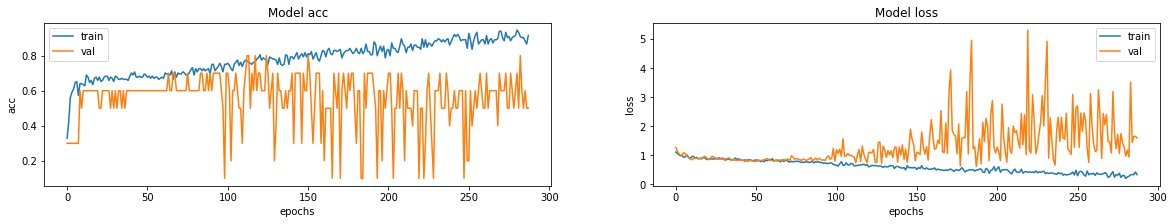

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(cnn.history.history[metric])
    ax[i].plot(cnn.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
cnn.load_weights("final_dmn_model.h5")

In [ ]:
# Compile model
cnn.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)
print("Created model and loaded weights from file")

Created model and loaded weights from file


In [ ]:
training_accuracy = cnn.evaluate(train_dataset, verbose = 0)
validation_accuracy = cnn.evaluate(validation_dataset, verbose = 0)
print("training", "%s: %.2f%%" % (cnn.metrics_names[1], training_accuracy[1]*100))
print("validation", "%s: %.2f%%" % (cnn.metrics_names[1], validation_accuracy[1]*100))

training acc: 95.12%
validation acc: 70.00%


In [ ]:
""" Join trainingset and validation set """

x_sample = np.concatenate((worsen_maps, nochange_maps, improve_maps), axis=0)
y_sample = np.concatenate((worsen_labels, nochange_labels, improve_labels), axis=0)

def sample_preprocessing(volume, label):
    """Add one dimension to each RSFCMaps in the test set."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

# Define data loaders
sample_loader = tf.data.Dataset.from_tensor_slices((x_sample, y_sample))

samp = (
    sample_loader
    .map(validation_preprocessing)
    .batch(1)
)


In [ ]:
""" Create Confusion Matrix """

from sklearn import metrics

y_pred = cnn.predict_classes(samp)

print(metrics.confusion_matrix(y_sample, y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


DMN Confusion Matrix /n
[[10  0  1]
 [ 0  4  2]
 [ 0  1 33]]


Balanced Accuracy = (10/11 + 4/6 + 33/34) /3 = 85 %